In [301]:
from pharynx_redox import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da,
    utils
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import skfda
from skfda.representation import FDataGrid, FDataBasis
from scipy import ndimage as ndi
import matplotlib as mpl
from matplotlib import cm
from matplotlib.colors import ListedColormap

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)
reload(utils)

pd.set_option('display.max_rows', 100)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [302]:
params = dict(
    experiment_dir=Path("/Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/"),
    imaging_scheme="TL/470/410/470/410",
    strategy='TEST'
)

# ex_unreg = experiment.PairExperiment(register=False, **params).full_pipeline()
# # ex_reg = experiment.PairExperiment(register=True, **params).full_pipeline()

ex_unreg = experiment.PairExperiment(register=False, **params).full_pipeline()
# ex_reg = experiment.PairExperiment(register=True, **params)
# ex_reg.trimmed_profiles = xr.load_dataarray('/Users/sean/Desktop/reg_with_new_params.nc')

04:05:07 INFO:Starting full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:05:07 INFO:Segmenting pharynxes
04:05:09 INFO:Centering and rotating pharynxes


04:05:18 INFO:Calculating midlines


04:05:19 INFO:Measuring under midlines


04:05:20 INFO:Trimming intensity data


04:05:21 INFO:Calculating redox measurements
04:05:21 INFO:Saving 2017_02_22-HD233_SAY47 inside /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47
04:05:21 INFO:Saving region means to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-23_TEST/2017_02_22-HD233_SAY47-summary_table.csv
04:05:21 INFO:Saving untrimmed profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-23_TEST/2017_02_22-HD233_SAY47-untrimmed_profile_data.nc
04:05:21 INFO:Saving trimmed profile data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-23_TEST/2017_02_22-HD233_SAY47-trimmed_profile_data.nc
04:05:21 INFO:Saving warp data to /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD233_SAY47/analyses/2019-09-23_TEST/2017_02_22-HD233_SAY47-warp_data.npy
04:05:21 INFO:Finished full pipeline run for /Users/sean/code/pharynx_redox/data/paired_ratio/2017_02_22-HD

In [259]:
i410_0 = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=0)
i470_0 = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=0)
i410_1 = ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=1)
i470_1 = ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=1)

r410_0 = ex_reg.trimmed_profiles.sel(wavelength='410', pair=0)
r470_0 = ex_reg.trimmed_profiles.sel(wavelength='470', pair=0)
r410_1 = ex_reg.trimmed_profiles.sel(wavelength='410', pair=1)
r470_1 = ex_reg.trimmed_profiles.sel(wavelength='470', pair=1)

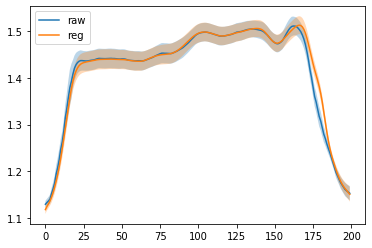

In [297]:
reg_profiles = ex_reg.trimmed_profiles
r_reg = (reg_profiles.sel(wavelength='410', pair=0) / reg_profiles.sel(wavelength='470', pair=0))
# r_reg = np.mean(r_reg - np.mean(r_reg, axis=1), axis=0)

r_raw = (ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=0) / ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=0))
# r_raw = np.mean(r_raw - np.mean(r_raw, axis=1), axis=0)

ax = plots.plot_profile_avg_with_bounds(r_raw, label='raw')
plots.plot_profile_avg_with_bounds(r_reg, ax=ax, label='reg')
plt.legend();

NameError: name 'warps' is not defined

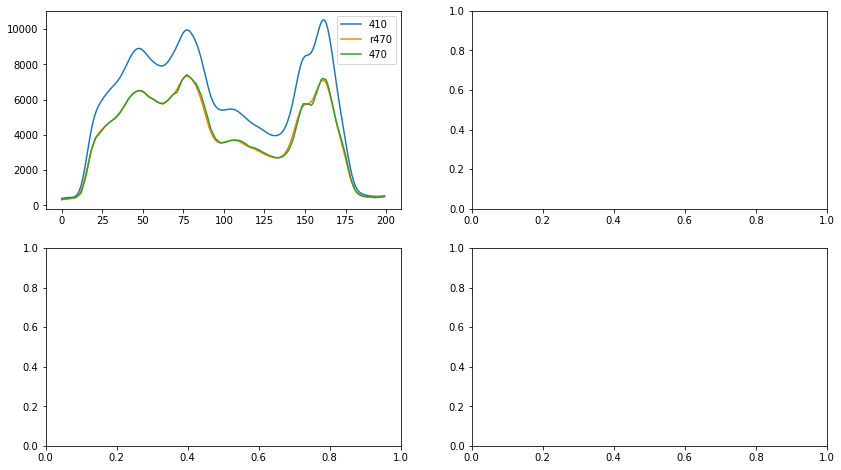

In [17]:
# plt.plot(np.linspace(1, 100, warps.shape[1]));
# plt.plot(warps[0][:,5]);
i = 0
fig, axes = plt.subplots(2,2,figsize=(14,8))
axes[0,0].plot(reg_profiles.sel(wavelength='410', pair=0)[i].T, label='410');
axes[0,0].plot(reg_profiles.sel(wavelength='470', pair=0)[i].T, label='r470');
axes[0,0].plot(ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=0)[i].T, label='470');
axes[0,0].legend();
# plt.figure()
axes[1,0].plot(
    np.linspace(1, 100, warps.shape[1]) - warps[0][:,i]
)
axes[1,0].axhline(0, linestyle='--')
axes[1,0].set_ylim(-1,1)
# axes[2].plot(np.linspace(1,100,200), linestyle='--')
# axes[2].plot(warps[0][:,i])
# axes[0].set_title(str(ex_unreg.movement.iloc[i]))

# plt.figure()
axes[1,1].imshow((ex_unreg.rot_fl.sel(wavelength='410', pair=0) / ex_unreg.rot_fl.sel(wavelength='470', pair=0))[i])


axes[0,1].plot(ex_unreg.untrimmed_profiles.sel(wavelength='410', pair=0)[i] / ex_unreg.untrimmed_profiles.sel(wavelength='470', pair=0)[i], label='raw')
axes[0,1].plot(reg_profiles.sel(wavelength='410', pair=0)[i] / reg_profiles.sel(wavelength='470', pair=0)[i], label='reg')
axes[0,1].legend()

In [22]:
all_mvmt = da.load_all_movement("/Users/sean/code/pharynx_redox/data/paired_ratio")

In [63]:
mvmt_wide = da.mvmt_long_to_wide(all_mvmt)

In [203]:
dfs[0].merge(dfs[1], on=['experiment', 'animal'], suffixes=('','_y'))
new_df.drop('movement_y', axis=1, level=0, inplace=True)

movement                                         \
region                        anterior    posterior    sides_of_tip    tip      
pair                                 0  1         0  1            0  1   0  1   
experiment             animal                                                   
2017_02_22-HD233_SAY47 0             0  0         0  0            0  0   1  0   
                       2             0  0         0  0            0  0   0  0   
                       3             0  0         0  0            0  0   0  0   
                       4             0  0         0  0            0  0   0  0   
                       7             0  0         0  0            0  0   0  0   
...                                ... ..       ... ..          ... ..  .. ..   
2017_08_25-HD233_SAY93 1             3  1         3  2            3  0   3  3   
                       12            2  1         1  1            2  1   2  1   
                       13            2  2         0  1            2  2   2  2   
                       20            1  1         0  0            0  0   1  1   
                       29            1  1         1  1            0  0   1  0   

                              movement_type_anterior movement_type_tip  
region                                                                  
pair                                                                    
experiment             animal                                           
2017_02_22-HD233_SAY47 0                       m_0_0             m_1_0  
                       2                       m_0_0             m_0_0  
                       3                       m_0_0             m_0_0  
                       4                       m_0_0             m_0_0  
                       7                       m_0_0             m_0_0  
...                                              ...               ...  
2017_08_25-HD233_SAY93 1                       m_1_1             m_1_1  
                       12                      m_1_1             m_1_1  
                       13                      m_1_1             m_1_1  
                       20                      m_1_1             m_1_1  
                       29                      m_1_1             m_1_0  

[740 rows x 10 columns]

In [211]:
m_0_0, m_0_1, m_1_0, m_1_1 = da.split_by_movement_types(mvmt_wide, region, t=0)

In [282]:
from functools import reduce

m_wide = mvmt_wide.copy()
for region in all_mvmt.region.unique():
    m_0_0, m_0_1, m_1_0, m_1_1 = da.split_by_movement_types(mvmt_wide, region, t=0)
    
    m_wide['movement_type_' + region] = ''
    m_wide.loc[m_0_0.index.values, 'movement_type_' + region] = '0_0'
    m_wide.loc[m_0_1.index.values, 'movement_type_' + region] = '0_1'
    m_wide.loc[m_1_0.index.values, 'movement_type_' + region] = '1_0'
    m_wide.loc[m_1_1.index.values, 'movement_type_' + region] = '1_1'

m_wide.reset_index(inplace=True)
m_wide = m_wide[m_wide.experiment == '2017_02_22-HD233_SAY47']

In [309]:
stationary = m_wide[m_wide['movement_type_posterior'] == '0_0'].index.values
moving = m_wide[m_wide['movement_type_posterior'].isin(['1_0', '0_1'])].index.values

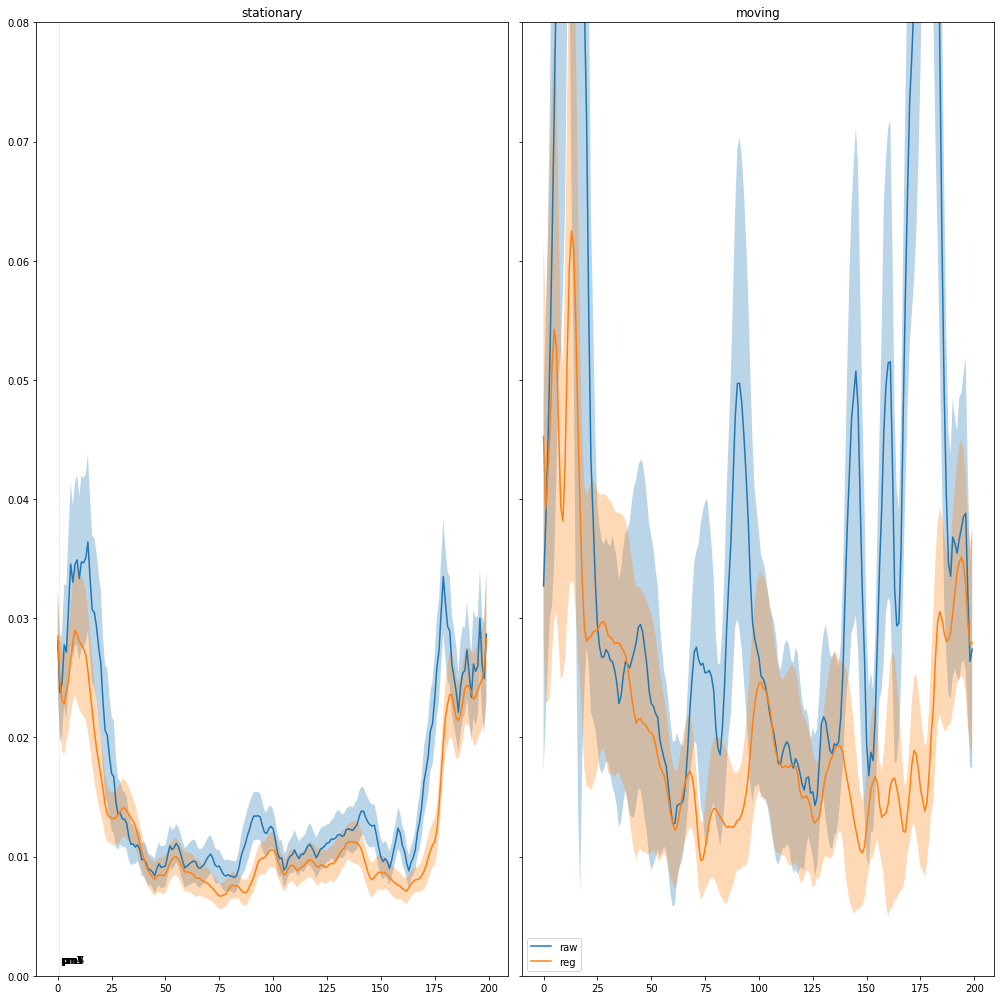

In [318]:
rr_reg = (np.abs(1-((r410_0/r470_0)/(r410_1/r470_1))))
rr_raw = (np.abs(1-((i410_0/i470_0)/(i410_1/i470_1))))

fig, ax = plt.subplots(1,2,figsize=(14,14), sharey='all', sharex='all');
# plots.plot_profile_avg_with_bounds(rr_raw, ax=ax, label='raw')
# plots.plot_profile_avg_with_bounds(rr_reg, ax=ax, label='reg')
plots.plot_profile_avg_with_bounds(rr_raw[stationary], ax=ax[0], label='raw');
plots.plot_profile_avg_with_bounds(rr_reg[stationary], ax=ax[0], label='reg');
ax[0].set_title('stationary')

plots.plot_profile_avg_with_bounds(rr_raw[moving], ax=ax[1], label='raw');
plots.plot_profile_avg_with_bounds(rr_reg[moving], ax=ax[1], label='reg');
ax[1].set_title('moving')
plots.add_regions_to_axis(regions=ex_unreg.untrimmed_regions, ax=ax[0])
plt.ylim(0,0.08);
plt.legend();
plt.tight_layout();